In [47]:
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pickle

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
num_dict = {'Unknown': '', '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four', '5': 'five', '6': 'six',
            '7': 'seven', '8': 'eight', '9': 'nine'}
def nums_to_sym(x: str) -> list:
    res = []
    for sym in x:
        if sym.isdigit():
            elem = num_dict[sym]
            res.append(elem)
        else:
            res.append(sym)
    return ''.join(res).split()

In [3]:
def join_corpnames(x: str) -> list:
    orig = x.split(', ')
    res = []
    for name in orig:
        elem = name.replace(' ', '')
        res.append(elem)
    return res

In [4]:
df_1 = pd.read_csv('anime.csv', dtype='str', keep_default_na=False)
df_2 = pd.read_csv('anime_with_synopsis.csv', dtype='str', keep_default_na=False)

In [5]:
df = df_1.merge(df_2, how='left', on=['MAL_ID', 'Name', 'Score', 'Genres'])

In [6]:
df = df[['Name', 'Genres', 'English name', 'Type', 'Premiered', 'Producers',
         'Licensors', 'Studios', 'Source', 'Rating', 'sypnopsis']]

In [7]:
df['Title'] = df['Name'].apply(lambda x: x.split())
df['Genres'] = df['Genres'].apply(lambda x: x.split(', '))
df['English name'] = df['English name'].apply(lambda x: x.split())

<AxesSubplot:xlabel='Type', ylabel='count'>

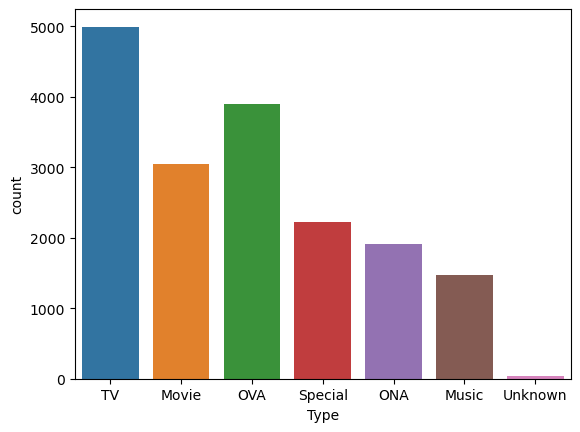

In [8]:
sns.countplot(x=df['Type'])

In [9]:
df['Type'] = df['Type'].replace({'Unknown': ''}).apply(lambda x: x.split())

In [10]:
df['Premiered'] = df['Premiered'].apply(lambda x: x.split()[1][-2:] if len(x.split()) > 1 else x)\
                                 .replace({'Unknown': ''}).apply(nums_to_sym)

In [11]:
df['Producers'] = df['Producers'].apply(join_corpnames)
df['Licensors'] = df['Licensors'].apply(join_corpnames)
df['Studios'] = df['Studios'].apply(join_corpnames)

In [12]:
df['Source'] = df['Source'].replace({'Unknown': ''}).apply(join_corpnames)

In [13]:
df['Rating'] = df['Rating'].replace({'R - 17+ (violence & profanity)': 'violenceprofanity',
                                     'PG-13 - Teens 13 or older': 'teens', 'PG - Children': 'children',
                                     'R+ - Mild Nudity': 'mildnudity', 'G - All Ages': 'allages',
                                     'Rx - Hentai': 'hentai', 'Unknown': ''}).apply(lambda x: x.split())

In [14]:
df['sypnopsis'].fillna('', inplace=True)
df['sypnopsis'] = df['sypnopsis'].apply(lambda x: x.split())

In [15]:
df['All_tags'] = df['Title'] + df['Genres'] + df['English name'] + df['Type'] + df['Premiered'] + df['Producers'] + \
                 df['Licensors'] + df['Studios'] + df['Source'] + df['Rating'] + df['sypnopsis']

In [16]:
stemmer = PorterStemmer()

In [17]:
df['All_tags'] = df['All_tags'].apply(lambda x: [stemmer.stem(el) for el in x])
df['All_tags'] = df['All_tags'].apply(lambda x: ' '.join(x))

In [19]:
cv = CountVectorizer(stop_words='english')
data = cv.fit_transform(df['All_tags']).toarray()
similarity = cosine_similarity(data)

In [44]:
def movie_recommend(movie):
    index = df[df['Name'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])
    for i in distances[1:8]:
        print("{}".format(df.iloc[i[0]]['Name']))

In [46]:
movie_recommend('Kimetsu no Yaiba')

Maou Gakuin no Futekigousha: Shijou Saikyou no Maou no Shiso, Tensei shite Shison-tachi no Gakkou e
Kimetsu no Yaiba Movie: Mugen Ressha-hen
Omamori Himari
Shinmai Maou no Testament
Yao Shen Ji
Kouchuu Ouja Mushiking: Mori no Tami no Densetsu
Chichi to Ko


In [48]:
pickle.dump(df, open('anime_recs.pkl', 'wb'))
pickle.dump(similarity, open('similarity.pkl', 'wb'))